In [1]:
!pip install efficientnet_pytorch
!pip install timm==0.4.5

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import os
from PIL import Image
import torchvision.transforms as transforms
import numpy as np

In [16]:
class AffectNetDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None, target_transform=None):
        self.data = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        self.target_transform = target_transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img_name = self.data.iloc[idx, 1]
        img_path = os.path.join(self.root_dir, f"class00{self.data.iloc[idx, 0]}", img_name)
        image = Image.open(img_path).convert("RGB")
        
        pyr_data = self.data.iloc[idx, 2:].to_numpy(dtype=np.float32)
        label = self.data.iloc[idx, 0] - 1 # -1 because classes start at 1
        
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
            
        return image, pyr_data, label

In [17]:
train_csv = "/kaggle/input/affectnet-csvs/affectnet_train_direction.csv"
val_csv = "/kaggle/input/affectnet-csvs/affectnet_val_direction.csv"

train_dir = "/kaggle/input/affectnet/affectnet/train"
val_dir = "/kaggle/input/affectnet/affectnet/val_class"

In [18]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [19]:
train_dataset = AffectNetDataset(train_csv, train_dir, transform=transform)
val_dataset = AffectNetDataset(val_csv, val_dir, transform=transform)

In [20]:
batch_size = 82
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [22]:
class ProposedModel(nn.Module):
    def __init__(self, efficientnet_model, num_tabular_features, num_classes):
        super(ProposedModel, self).__init__()
        self.efficientnet_model = efficientnet_model
        self.fc = nn.Linear(12, num_classes) # change ._fc to .classifier if using the pretrained model from github
        
    def forward(self, image, tabular_features):
        image_features = self.efficientnet_model(image)
        combined_features = torch.cat((tabular_features, image_features), dim=1)
        output = self.fc(combined_features)
        return output

In [23]:
from efficientnet_pytorch import EfficientNet
import timm

num_classes = 8
efficientnet_model = EfficientNet.from_name('efficientnet-b2')
efficientnet_model._fc = torch.nn.Linear(efficientnet_model._fc.in_features, num_classes)
efficientnet_model.state_dict = torch.load("/kaggle/input/effnet-b2/enet_b2_8_best.pt")
model = ProposedModel(efficientnet_model, 4, num_classes)
model.to(device)

model.eval()

ProposedModel(
  (efficientnet_model): EfficientNet(
    (_conv_stem): Conv2dStaticSamePadding(
      3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
      (static_padding): ZeroPad2d((0, 1, 0, 1))
    )
    (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (_blocks): ModuleList(
      (0): MBConvBlock(
        (_depthwise_conv): Conv2dStaticSamePadding(
          32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
          (static_padding): ZeroPad2d((1, 1, 1, 1))
        )
        (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
        (_se_reduce): Conv2dStaticSamePadding(
          32, 8, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_se_expand): Conv2dStaticSamePadding(
          8, 32, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_project_conv): Conv2dStat

In [24]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [25]:
from tqdm import tqdm
num_epochs = 20

train_accuracies = []
val_accuracies = []

train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    correct = 0
    total = 0

    for images, tabular_features, labels in tqdm(train_dataloader):
        
        images = images.to(device)
        tabular_features = tabular_features.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(images, tabular_features)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

        train_loss += loss.item()

    train_accuracy = 100 * correct / total
    train_accuracies.append(train_accuracy)
    
    avg_train_loss = train_loss / len(train_dataloader)
    train_losses.append(avg_train_loss)

    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    model.eval()
    with torch.no_grad():
        for images, tabular_features, labels in val_dataloader:
            
            images = images.to(device)
            tabular_features = tabular_features.to(device)
            labels = labels.to(device)

            outputs = model(images, tabular_features)
            loss = criterion(outputs, labels)

            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            val_loss += loss.item()

    val_accuracy = 100 * correct / total
    val_accuracies.append(val_accuracy)
    avg_val_loss = val_loss / len(val_dataloader)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch+1}/{num_epochs}:\n"
          f"Train Loss: {avg_train_loss:.4f} | Train Accuracy: {train_accuracy:.2f}%\n"
          f"Val Loss: {avg_val_loss:.4f} | Val Accuracy: {val_accuracy:.2f}%\n")


100%|██████████| 376/376 [09:44<00:00,  1.55s/it]


Epoch 1/20:
Train Loss: 2.0829 | Train Accuracy: 14.68%
Val Loss: 2.0614 | Val Accuracy: 16.58%



100%|██████████| 376/376 [07:12<00:00,  1.15s/it]


Epoch 2/20:
Train Loss: 1.8805 | Train Accuracy: 25.43%
Val Loss: 1.9449 | Val Accuracy: 28.51%



100%|██████████| 376/376 [07:13<00:00,  1.15s/it]


Epoch 3/20:
Train Loss: 1.6665 | Train Accuracy: 34.35%
Val Loss: 1.6463 | Val Accuracy: 36.50%



100%|██████████| 376/376 [07:12<00:00,  1.15s/it]


Epoch 4/20:
Train Loss: 1.5062 | Train Accuracy: 41.63%
Val Loss: 1.6444 | Val Accuracy: 38.08%



100%|██████████| 376/376 [07:14<00:00,  1.16s/it]


Epoch 5/20:
Train Loss: 1.3721 | Train Accuracy: 47.90%
Val Loss: 1.4851 | Val Accuracy: 43.89%



100%|██████████| 376/376 [07:12<00:00,  1.15s/it]


Epoch 6/20:
Train Loss: 1.2679 | Train Accuracy: 52.04%
Val Loss: 1.4917 | Val Accuracy: 46.70%



100%|██████████| 376/376 [07:20<00:00,  1.17s/it]


Epoch 7/20:
Train Loss: 1.1764 | Train Accuracy: 55.76%
Val Loss: 1.4552 | Val Accuracy: 48.10%



100%|██████████| 376/376 [07:13<00:00,  1.15s/it]


Epoch 8/20:
Train Loss: 1.0914 | Train Accuracy: 59.47%
Val Loss: 1.5514 | Val Accuracy: 46.16%



100%|██████████| 376/376 [07:15<00:00,  1.16s/it]


Epoch 9/20:
Train Loss: 1.0022 | Train Accuracy: 62.69%
Val Loss: 1.5267 | Val Accuracy: 47.49%



100%|██████████| 376/376 [07:12<00:00,  1.15s/it]


Epoch 10/20:
Train Loss: 0.9092 | Train Accuracy: 65.98%
Val Loss: 1.6215 | Val Accuracy: 46.19%



100%|██████████| 376/376 [07:23<00:00,  1.18s/it]


Epoch 11/20:
Train Loss: 0.8128 | Train Accuracy: 70.01%
Val Loss: 1.6511 | Val Accuracy: 46.70%



100%|██████████| 376/376 [07:36<00:00,  1.21s/it]


Epoch 12/20:
Train Loss: 0.7044 | Train Accuracy: 74.09%
Val Loss: 1.7936 | Val Accuracy: 47.59%



100%|██████████| 376/376 [07:40<00:00,  1.22s/it]


Epoch 13/20:
Train Loss: 0.6123 | Train Accuracy: 77.78%
Val Loss: 1.9324 | Val Accuracy: 45.09%



100%|██████████| 376/376 [07:39<00:00,  1.22s/it]


Epoch 14/20:
Train Loss: 0.5372 | Train Accuracy: 80.33%
Val Loss: 2.1072 | Val Accuracy: 46.90%



100%|██████████| 376/376 [07:34<00:00,  1.21s/it]


Epoch 15/20:
Train Loss: 0.4663 | Train Accuracy: 83.37%
Val Loss: 2.3372 | Val Accuracy: 45.55%



100%|██████████| 376/376 [07:29<00:00,  1.19s/it]


Epoch 16/20:
Train Loss: 0.4043 | Train Accuracy: 85.36%
Val Loss: 2.2923 | Val Accuracy: 46.47%



100%|██████████| 376/376 [07:28<00:00,  1.19s/it]


Epoch 17/20:
Train Loss: 0.3599 | Train Accuracy: 87.07%
Val Loss: 2.6062 | Val Accuracy: 46.37%



100%|██████████| 376/376 [07:24<00:00,  1.18s/it]


Epoch 18/20:
Train Loss: 0.3270 | Train Accuracy: 88.48%
Val Loss: 2.7559 | Val Accuracy: 45.75%



100%|██████████| 376/376 [07:27<00:00,  1.19s/it]


Epoch 19/20:
Train Loss: 0.2955 | Train Accuracy: 89.74%
Val Loss: 2.8330 | Val Accuracy: 46.65%



100%|██████████| 376/376 [07:37<00:00,  1.22s/it]


Epoch 20/20:
Train Loss: 0.2786 | Train Accuracy: 90.39%
Val Loss: 2.7689 | Val Accuracy: 46.19%



### Balanced dataset (equal number of images per direction)

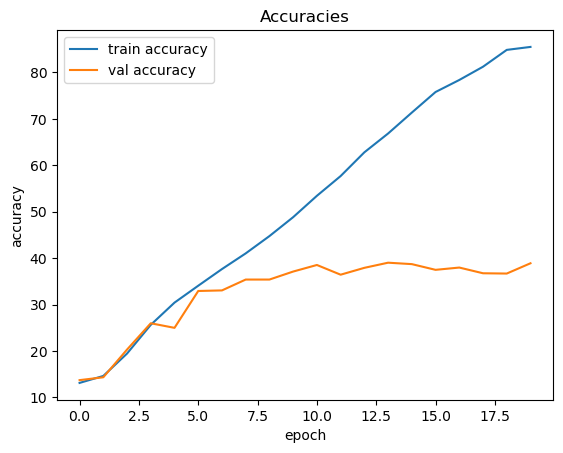

In [14]:
import matplotlib.pyplot as plt
import numpy as np

plt.plot(np.arange(len(train_accuracies)), train_accuracies)
plt.plot(np.arange(len(val_accuracies)), val_accuracies)
plt.title("Accuracies")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend(["train accuracy", "val accuracy"])
plt.show()

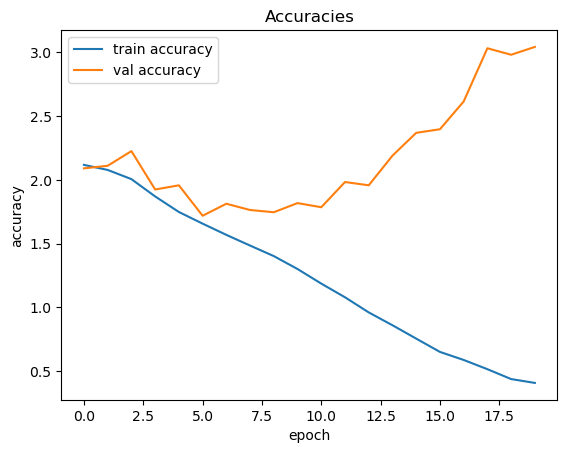

In [15]:
plt.plot(np.arange(len(train_losses)), train_losses)
plt.plot(np.arange(len(val_losses)), val_losses)
plt.title("Accuracies")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend(["train accuracy", "val accuracy"])
plt.show()

Other than clearly too many epochs and overtraining, the model seems to have not enough data to learn well

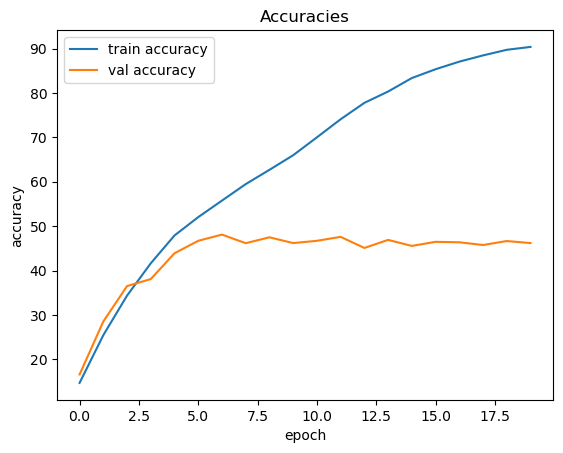

In [26]:
import matplotlib.pyplot as plt
import numpy as np

plt.plot(np.arange(len(train_accuracies)), train_accuracies)
plt.plot(np.arange(len(val_accuracies)), val_accuracies)
plt.title("Accuracies")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend(["train accuracy", "val accuracy"])
plt.show()

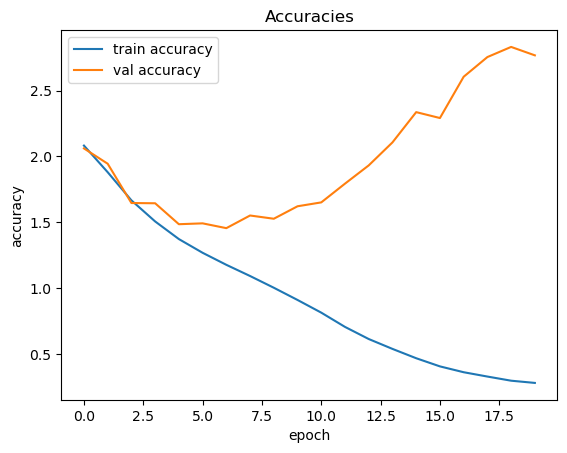

In [28]:
plt.plot(np.arange(len(train_losses)), train_losses)
plt.plot(np.arange(len(val_losses)), val_losses)
plt.title("Accuracies")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend(["train accuracy", "val accuracy"])
plt.show()